## FSL-1

In [2]:
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torch.utils.data.sampler import Sampler
import numpy as np
import matplotlib.pyplot as plt
import random
classes_per_batch__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        return nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [71]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

else:
    mps_device = torch.device("mps")

In [4]:
mps_device = 'cuda'

In [5]:
# Define Siamese Network
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            # nn.
            # nn.MaxPool2d(2),
            # nn.Conv2d(128, 128, kernel_size=4),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
            # nn.Conv2d(128, 256, kernel_size=4),
            # nn.ReLU(inplace=True)
        )
        self.gap = GlobalAvgPool2d()

        self.fc = nn.Sequential(
            nn.Linear(128, 512),
            nn.Sigmoid()
        )
        
    def forward_one(self, x):
        x = self.cnn(x)
        x = self.gap(x)
        # x = x.view(x.size()[0], -1)
        x = self.fc(x.T)
        return x
    
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


class SiameseSampler(Sampler):
    def __init__(self, data_source, classes_per_batch=10, samples_per_class=4):
        self.data_source = data_source
        self.classes_per_batch = classes_per_batch
        self.samples_per_class = samples_per_class
        self.class_indices = {label.item(): [] for label in self.data_source.targets}
        for idx, label in enumerate(self.data_source.targets):
            self.class_indices[label.item()].append(idx)
            
    def __iter__(self):
        batch_indices = []
        for _ in range(self.classes_per_batch):
            selected_classes = random.sample(range(10), self.samples_per_class) 
            for class_label in selected_classes:
                selected_indices = random.sample(self.class_indices[class_label], self.samples_per_class)
                batch_indices.append(selected_indices)
        return iter(batch_indices)
    
    def __len__(self):
        return self.classes_per_batch

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='mnist_data', train=True, download=True, transform=transform)
train_sampler = SiameseSampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)


In [6]:
test_dataset = MNIST(root='mnist_data', train=False, download=True, transform=transform)
test_sampler = SiameseSampler(test_dataset,classes_per_batch=10,samples_per_class=1)
test_loader = DataLoader(test_dataset, batch_sampler=test_sampler)

In [7]:

# Initialize Model, Loss Function, and Optimizer
model = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(mps_device)



SiameseNetwork(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
  )
  (gap): GlobalAvgPool2d()
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): Sigmoid()
  )
)

In [8]:
# Training Loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        img1, img2 = data[0], data[1]
        target = torch.tensor(target)
        optimizer.zero_grad()
        output1, output2 = model(img1.to(mps_device), img2.to(mps_device))
        loss = criterion(output1, output2, target.to(mps_device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss}")

torch.save(model.state_dict(), 'siamese_model_mnist.pth')


/tmp/ipykernel_5395/2353844553.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Epoch 1, Loss: -2980.4776084162295
Epoch 2, Loss: -9092.775305509567
Epoch 3, Loss: -10903.020587995296
Epoch 4, Loss: -19636.169190883636
Epoch 5, Loss: -16515.623197302222
Epoch 6, Loss: -13876.820745587349
Epoch 7, Loss: -34838.12713384628
Epoch 8, Loss: -29720.978462465107
Epoch 9, Loss: -21624.031155880075
Epoch 10, Loss: -29054.038786061294
Epoch 11, Loss: -19415.652008603985
Epoch 12, Loss: -33584.33856609464
Epoch 13, Loss: -30595.618522635305
Epoch 14, Loss: -32401.137440502644
Epoch 15, Loss: -33754.533679790155
Epoch 16, Loss: -29298.45156550292
Epoch 17, Loss: -25279.766416570666
Epoch 18, Loss: -6400.65763693238
Epoch 19, Loss: -21800.59276738916
Epoch 20, Loss: -16107.132632560359
Epoch 21, Loss: -27283.82874584198
Epoch 22, Loss: -33893.62995306569
Epoch 23, Loss: -28540.51843392849
Epoch 24, Loss: -32373.72673267126
Epoch 25, Loss: -19966.185228575407
Epoch 26, Loss: -21393.35954298079
Epoch 27, Loss: -21598.172987386584
Epoch 28, Loss: -34440.04182934761
Epoch 29, Loss

In [9]:
len(train_loader)

10

In [10]:
for data, target in train_loader:
    # print(data)
    print(data.shape,target.shape)

torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size([4, 1, 28, 28]) torch.Size([4])
torch.Size(

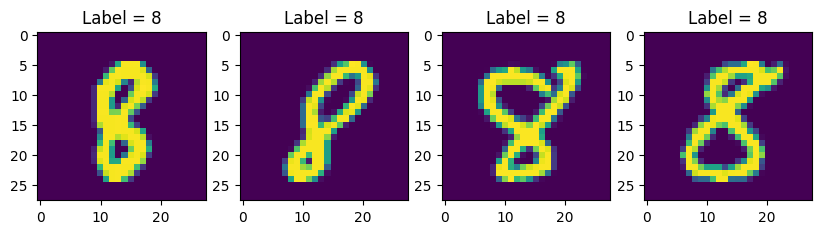

In [11]:

fig = plt.figure(figsize=(10, 10)) 


for i in range(1,5):


    fig.add_subplot(1,4,i)
    plt.title(f'Label = {target[i-1]}')
    plt.imshow(data[i-1].permute((1,2,0)))


# for i in range(4):
    

In [12]:

num_epochs = 1

embeddings  = []


model.zero_grad()
total_loss = 0
for batch_idx, (data, target) in enumerate(train_loader):
    img1, img2 = data[0], data[1]
    target = torch.tensor(target)
    optimizer.zero_grad()
    output1, output2 = model(img1.to(mps_device), img2.to(mps_device))
    embeddings.append([output1,target[0]])

/tmp/ipykernel_5395/1602431124.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


In [13]:
len(embeddings)

40

In [14]:
labels = torch.zeros(40,dtype=torch.int)

for i in range(40):
    labels[i] = embeddings[i][1]
    print(embeddings[i][1])

tensor(5)
tensor(6)
tensor(2)
tensor(1)
tensor(5)
tensor(4)
tensor(2)
tensor(3)
tensor(9)
tensor(1)
tensor(0)
tensor(2)
tensor(0)
tensor(8)
tensor(5)
tensor(1)
tensor(5)
tensor(8)
tensor(9)
tensor(7)
tensor(5)
tensor(8)
tensor(1)
tensor(2)
tensor(6)
tensor(3)
tensor(2)
tensor(9)
tensor(2)
tensor(1)
tensor(5)
tensor(4)
tensor(8)
tensor(9)
tensor(3)
tensor(4)
tensor(0)
tensor(1)
tensor(4)
tensor(2)


In [15]:
embeddingsFin = torch.zeros((40,512))
for i in range(40):
    embeddingsFin[i] = embeddings[i][0].squeeze()
    print(embeddings[i][1])

tensor(5)
tensor(6)
tensor(2)
tensor(1)
tensor(5)
tensor(4)
tensor(2)
tensor(3)
tensor(9)
tensor(1)
tensor(0)
tensor(2)
tensor(0)
tensor(8)
tensor(5)
tensor(1)
tensor(5)
tensor(8)
tensor(9)
tensor(7)
tensor(5)
tensor(8)
tensor(1)
tensor(2)
tensor(6)
tensor(3)
tensor(2)
tensor(9)
tensor(2)
tensor(1)
tensor(5)
tensor(4)
tensor(8)
tensor(9)
tensor(3)
tensor(4)
tensor(0)
tensor(1)
tensor(4)
tensor(2)


In [16]:
embeddingsFin[0].shape

torch.Size([512])

In [17]:
labels

tensor([5, 6, 2, 1, 5, 4, 2, 3, 9, 1, 0, 2, 0, 8, 5, 1, 5, 8, 9, 7, 5, 8, 1, 2,
        6, 3, 2, 9, 2, 1, 5, 4, 8, 9, 3, 4, 0, 1, 4, 2], dtype=torch.int32)

In [18]:
embeddingsFin

tensor([[1.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.4125e-24,  ..., 5.4364e-25, 1.2195e-16,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 3.5718e-29,  ..., 4.8589e-29, 1.1376e-21,
         1.0000e+00],
        ...,
        [1.0000e+00, 1.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 4.2394e-27,  ..., 7.8367e-27, 8.4924e-20,
         1.0000e+00],
        [1.0000e+00, 1.0000e+00, 8.5006e-30,  ..., 3.3172e-30, 3.3976e-20,
         1.0000e+00]], grad_fn=<CopySlices>)

In [19]:
embeddings[0][0].shape

torch.Size([1, 512])

In [20]:
embeddings[0][1].shape

torch.Size([])

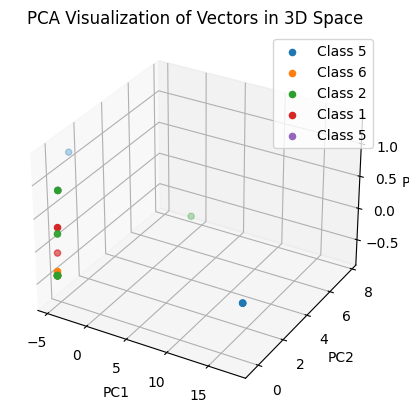

In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Generate some random vectors in 512-dimensional space
num_vectors = 40
dim = 512
vectors = embeddingsFin.detach().cpu()

# Perform PCA for dimensionality reduction
pca = PCA(n_components=3)
vectors_3d = pca.fit_transform(vectors)

# Generate some random class labels for demonstration
classes = labels.detach().cpu()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(5):  # Plotting each class separately
    indices = (classes == i).nonzero().squeeze()
    # print(indices)
    ax.scatter(vectors_3d[indices, 0], vectors_3d[indices, 1], vectors_3d[indices, 2], label=f'Class {classes[i]}')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA Visualization of Vectors in 3D Space')
ax.legend()

plt.show()


In [23]:

num_epochs = 1

embeddings  = []


model.zero_grad()
total_loss = 0

for batch_idx, (data_test, target_test) in enumerate(test_loader):

    for batch_idx, (data, target) in enumerate(train_loader):
        img1, img2 = data[0], data[1]
        target = torch.tensor(target)
        optimizer.zero_grad()
        output1, output2 = model(img1.to(mps_device), img2.to(mps_device))
        embeddings.append([output1,target[0]])

/tmp/ipykernel_5395/3701420911.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


## Inferencing

In [24]:

embeddingsx  = []


model.zero_grad()
total_loss = 0


finalLosses =[]

for batch_idx, (data_test, target_test) in enumerate(test_loader):
    lossCurr = []
    # print(data_test.shape,target_test.shape)
    for batch_idx, (data, target) in enumerate(train_loader):
        img1 = data_test[0]
        img2 = data[0]


        target_train = torch.tensor(target)
        optimizer.zero_grad()
        output1, output2 = model(img1.to(mps_device), img2.to(mps_device))
        embeddings.append([output1,target[0]])

        loss = criterion(output1, output2, target.to(mps_device))
        lossCurr.append([target_train[0],torch.tensor(target_test),loss.detach().cpu()])
    finalLosses.append(lossCurr)
    


/tmp/ipykernel_5395/3984306244.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_train = torch.tensor(target)
/tmp/ipykernel_5395/3984306244.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lossCurr.append([target_train[0],torch.tensor(target_test),loss.detach().cpu()])


In [25]:
for i in range(10):

    lossXs = finalLosses[i]
    lossesX = []

    for i in range(40):
        lossesX.append(lossXs[i][2].item())

    lossesX = np.array(lossesX)
    print(lossXs[np.argmin(np.abs(lossesX))])

[tensor(1), tensor([5]), tensor(0.)]
[tensor(1), tensor([6]), tensor(0.)]
[tensor(0), tensor([1]), tensor(0.0002)]
[tensor(1), tensor([6]), tensor(0.)]
[tensor(1), tensor([8]), tensor(0.0206)]
[tensor(9), tensor([9]), tensor(0.4553)]
[tensor(9), tensor([6]), tensor(0.6762)]
[tensor(0), tensor([2]), tensor(0.8934)]
[tensor(2), tensor([2]), tensor(-0.1230)]
[tensor(0), tensor([3]), tensor(0.0110)]


## W/O CNN

In [26]:
# Define Siamese Network
class SiameseNetwork2(nn.Module):
    def __init__(self):
        super(SiameseNetwork2, self).__init__()
        self.cnn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),  # Bottleneck layer
        )
        # self.gap = GlobalAvgPool2d()

        # self.fc = nn.Sequential(
        #     nn.Linear(128, 512),
        #     nn.Sigmoid()
        # )
        
    def forward_one(self, x):
        x = self.cnn(x)
        # x = self.gap(x)
        # x = x.view(x.size()[0], -1)
        # x = self.fc(x.T)
        return x
    
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


class SiameseSampler(Sampler):
    def __init__(self, data_source, classes_per_batch=10, samples_per_class=4):
        self.data_source = data_source
        self.classes_per_batch = classes_per_batch
        self.samples_per_class = samples_per_class
        self.class_indices = {label.item(): [] for label in self.data_source.targets}
        for idx, label in enumerate(self.data_source.targets):
            self.class_indices[label.item()].append(idx)
            
    def __iter__(self):
        batch_indices = []
        for _ in range(self.classes_per_batch):
            selected_classes = random.sample(range(10), self.samples_per_class) 
            for class_label in selected_classes:
                selected_indices = random.sample(self.class_indices[class_label], self.samples_per_class)
                batch_indices.append(selected_indices)
        return iter(batch_indices)
    
    def __len__(self):
        return self.classes_per_batch

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='mnist_data', train=True, download=True, transform=transform)
train_sampler = SiameseSampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_sampler=train_sampler)


In [27]:

# Initialize Model, Loss Function, and Optimizer
model = SiameseNetwork2()
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model.to(mps_device)



SiameseNetwork2(
  (cnn): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU(inplace=True)
    (7): Linear(in_features=128, out_features=64, bias=True)
  )
)

In [28]:
# Training Loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        img1, img2 = data[0], data[1]
        target = torch.tensor(target)
        optimizer.zero_grad()
        output1, output2 = model(img1.to(mps_device), img2.to(mps_device))
        loss = criterion(output1, output2, target.to(mps_device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss}")

torch.save(model.state_dict(), 'siamese_model_mnist.pth')


/tmp/ipykernel_5395/2353844553.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


Epoch 1, Loss: -1130.3816400635988
Epoch 2, Loss: -52242656.28417969
Epoch 3, Loss: -5452309384.971069
Epoch 4, Loss: -214163463890.5
Epoch 5, Loss: -7006280322576.0
Epoch 6, Loss: -50804645257664.0
Epoch 7, Loss: -649347503766528.0
Epoch 8, Loss: -2917927436476416.0
Epoch 9, Loss: -9393625426503168.0
Epoch 10, Loss: -1.4427517900849152e+16
Epoch 11, Loss: -2.124040397180109e+16
Epoch 12, Loss: -4.613090017469645e+16
Epoch 13, Loss: -1.660174356274217e+17
Epoch 14, Loss: -1.9047570724501914e+17
Epoch 15, Loss: -3.879691573470167e+17
Epoch 16, Loss: -1.3856649692850422e+18
Epoch 17, Loss: -2.2348638831055892e+18
Epoch 18, Loss: -5.045715048622719e+18
Epoch 19, Loss: -8.962975882528424e+18
Epoch 20, Loss: -6.934002698278666e+18
Epoch 21, Loss: -1.8322232864977977e+19
Epoch 22, Loss: -2.634897901279091e+19
Epoch 23, Loss: -3.2788421446895403e+19
Epoch 24, Loss: -6.735469804734382e+19
Epoch 25, Loss: -5.588063543543149e+19
Epoch 26, Loss: -9.626650742945219e+19
Epoch 27, Loss: -1.715135327

In [29]:

num_epochs = 1

embeddings  = []


model.zero_grad()
total_loss = 0

for batch_idx, (data_test, target_test) in enumerate(test_loader):

    for batch_idx, (data, target) in enumerate(train_loader):
        img1, img2 = data[0], data[1]
        target = torch.tensor(target)
        optimizer.zero_grad()
        output1, output2 = model(img1.to(mps_device), img2.to(mps_device))
        embeddings.append([output1,target[0]])

/tmp/ipykernel_5395/3701420911.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target)


In [30]:

embeddingsx  = []


model.zero_grad()
total_loss = 0


finalLosses =[]

for batch_idx, (data_test, target_test) in enumerate(test_loader):
    lossCurr = []
    # print(data_test.shape,target_test.shape)
    for batch_idx, (data, target) in enumerate(train_loader):
        img1 = data_test[0]
        img2 = data[0]


        target_train = torch.tensor(target)
        optimizer.zero_grad()
        output1, output2 = model(img1.to(mps_device), img2.to(mps_device))
        embeddings.append([output1,target[0]])

        loss = criterion(output1, output2, target.to(mps_device))
        lossCurr.append([target_train[0],torch.tensor(target_test),loss.detach().cpu()])
    finalLosses.append(lossCurr)
    


/tmp/ipykernel_5395/3984306244.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_train = torch.tensor(target)
/tmp/ipykernel_5395/3984306244.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lossCurr.append([target_train[0],torch.tensor(target_test),loss.detach().cpu()])


In [31]:
for i in range(10):

    lossXs = finalLosses[i]
    lossesX = []

    for i in range(40):
        lossesX.append(lossXs[i][2].item())

    lossesX = np.array(lossesX)
    print(lossXs[np.argmin(np.abs(lossesX))])

[tensor(1), tensor([4]), tensor(0.)]
[tensor(1), tensor([0]), tensor(0.)]
[tensor(1), tensor([5]), tensor(0.)]
[tensor(1), tensor([1]), tensor(0.)]
[tensor(1), tensor([1]), tensor(0.)]
[tensor(1), tensor([5]), tensor(0.)]
[tensor(1), tensor([1]), tensor(0.)]
[tensor(1), tensor([3]), tensor(0.)]
[tensor(1), tensor([1]), tensor(0.)]
[tensor(1), tensor([7]), tensor(0.)]


## FSL-2

In [46]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, x):
        return nn.functional.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)


In [56]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Define Siamese network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
            
            # nn.Conv2d(128, 128, kernel_size=3),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
            # nn.Conv2d(128, 256, kernel_size=3),
            # nn.ReLU(inplace=True)
        )

        self.gap = GlobalAvgPool2d()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 1024),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.convolutional_layers(x)
        x = self.gap(x)
        x = x.view(x.size()[0], -1)
        x = self.fc_layers(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Define Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

# Custom Dataset for Siamese Network
class SiameseDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.transform = transforms.Compose([
            transforms.Resize((28, 28)),
            # transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __getitem__(self, index):
        img1, label1 = self.mnist_dataset[index]
        # Randomly select a second sample
        same_class = torch.rand(1).item() > 0.5
        if same_class:
            while True:
                img2, label2 = self.mnist_dataset[np.random.randint(len(self.mnist_dataset))]
                if label1 == label2:
                    break
        else:
            while True:
                img2, label2 = self.mnist_dataset[np.random.randint(len(self.mnist_dataset))]
                if label1 != label2:
                    break

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        return img1, img2, torch.tensor([int(label1 == label2)], dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_dataset)

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(SiameseDataset(train_dataset), batch_size=1, shuffle=True)


In [57]:
from tqdm import tqdm

In [59]:

siamese_net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=1e-4)


siamese_net.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    for i, img1, img2, label in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        output1, output2 = siamese_net(img1.to(device), img2.to(device))
        loss = criterion(output1, output2, label.to(device))
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Training finished!")


0it [00:00, ?it/s]


ValueError: not enough values to unpack (expected 4, got 2)

In [50]:
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(SiameseDataset(test_dataset), batch_size=1, shuffle=False)


In [52]:
siamese_net.eval()  # Set the model to evaluation mode
predictions = []

distX = []

threshold = 0.3

with torch.no_grad():
    for test_img,_, _ in tqdm(test_loader):
        distances = []
        for idx, (support_img, _, _) in enumerate(train_loader):
            output1, output2 = siamese_net(test_img.to(device), support_img.to(device))

            # print(output1.shape,output2.shape)

            euclidean_distance = nn.functional.pairwise_distance(output1, output2)
            # print(euclidean_distance)
            distances.append((euclidean_distance.item(), idx))  # Store distance and support image index
        
        # Find the index of the support image with the minimum distance
        min_distance, min_index = min(distances)

        distX.append(min_distance)

        predicted_label = train_dataset[min_index][1]  # Get the label of the nearest support image
        prediction = 1 if min_distance < threshold else 0
        predictions.append((prediction, predicted_label))

# Now you have the predictions for the test dataset along with the predicted labels
print(predictions)


  0%|          | 1/10000 [00:57<160:47:32, 57.89s/it]


KeyboardInterrupt: 

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Siamese network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True),
        )

        self.gap = GlobalAvgPool2d()

        self.fc = nn.Sequential(
            nn.Linear(256,512),
            nn.Sigmoid()
        )
    
    def forward_one(self, x):
        output = self.cnn(x)
        output = self.gap(output)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Define Contrastive Loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

# Custom dataset for MNIST
class SiameseMNIST(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.transform = transforms.Compose([
            transforms.Resize((28, 28)),
            # transforms.ToTensor()
        ])
        self.class_indices = self._create_class_indices()

    def _create_class_indices(self):
        class_indices = {}
        for i in range(len(self.mnist_dataset)):
            _, label = self.mnist_dataset[i]
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(i)
        return class_indices

    def __getitem__(self, index):
        label1 = index // 5
        label2 = np.random.choice(list(range(10)))
        while label2 == label1:
            label2 = np.random.choice(list(range(10)))
        img1_index = np.random.choice(self.class_indices[label1], 1)[0]
        img2_index = np.random.choice(self.class_indices[label2], 1)[0]
        img1, _ = self.mnist_dataset[img1_index]
        img2, _ = self.mnist_dataset[img2_index]
        label = 1 if label1 == label2 else 0
        img1 = self.transform(img1)
        img2 = self.transform(img2)
        return img1.to(device), img2.to(device), torch.tensor(label, dtype=torch.float32).to(device)

    def __len__(self):
        return 10 * 5

# Load MNIST dataset
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# Initialize Siamese network, loss function, and optimizer
siamese_net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(siamese_net.parameters(), lr=0.0005)

# Train the Siamese network
num_epochs = 20
batch_size = 128
train_loader = DataLoader(SiameseMNIST(mnist_dataset), batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    total_loss = 0.0
    for i, (img1, img2, label) in enumerate(train_loader):
        optimizer.zero_grad()
        output1, output2 = siamese_net(img1, img2)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

print("Training finished.")


Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0001
Epoch 3, Loss: 0.0000
Epoch 4, Loss: 0.0000
Epoch 5, Loss: 0.0000
Epoch 6, Loss: 0.0000
Epoch 7, Loss: 0.0000
Epoch 8, Loss: 0.0000
Epoch 9, Loss: 0.0000
Epoch 10, Loss: 0.0000
Epoch 11, Loss: 0.0000
Epoch 12, Loss: 0.0000
Epoch 13, Loss: 0.0000
Epoch 14, Loss: 0.0000
Epoch 15, Loss: 0.0000
Epoch 16, Loss: 0.0000
Epoch 17, Loss: 0.0000
Epoch 18, Loss: 0.0000
Epoch 19, Loss: 0.0000
Epoch 20, Loss: 0.0000
Training finished.


In [66]:
from sklearn.metrics.pairwise import euclidean_distances


In [68]:
# siamese_net.load_state_dict(torch.load("siamese_model.pth"))
siamese_net.eval()

# Load query dataset
query_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
query_loader = DataLoader(query_dataset, batch_size=1, shuffle=False)

# Get embeddings for query images
query_embeddings = []
query_labels = []
for img, label in query_loader:
    img = img.to(device)
    with torch.no_grad():
        output = siamese_net.forward_one(img)
    query_embeddings.append(output.cpu().numpy().flatten())
    query_labels.append(label.item())

# Load training dataset
train_dataset = SiameseMNIST(mnist_dataset)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# Get embeddings for training images
train_embeddings = []
train_labels = []
for img1, _, label in train_loader:
    img1 = img1.to(device)
    with torch.no_grad():
        output = siamese_net.forward_one(img1)
    train_embeddings.append(output.cpu().numpy().flatten())
    train_labels.append(label.item())

# Convert lists to numpy arrays
query_embeddings = np.array(query_embeddings)
train_embeddings = np.array(train_embeddings)

# Calculate pairwise distances between query and training embeddings
distances = euclidean_distances(query_embeddings, train_embeddings)

# Predict labels based on nearest neighbors
predicted_labels = np.argmin(distances, axis=1)

# Calculate accuracy
accuracy = np.mean(np.array(predicted_labels) == np.array(query_labels))
print(f"Accuracy: {accuracy}")


Accuracy: 0.0154
